In [7]:
import pyarrow.dataset as ds
import pandas as pd
import warnings
import pandas as pd
import numpy as np
import time
import pickle
import joblib
from datetime import datetime as dt
from hurst import compute_Hc
from scipy.signal import hilbert
from numba import njit
import pyarrow.dataset as ds
import pandas as pd
import warnings
import pandas as pd
import numpy as np
import time
import pickle
import joblib
from datetime import datetime as dt
from hurst import compute_Hc
from scipy.signal import hilbert
from numba import njit
warnings.filterwarnings("ignore")

low_buffer = []
high_buffer = []
rolling_lows = []
rolling_highs = []
close_buffer = []
pct_change_5_buffer = []   
pct_change_30_buffer = [] 
prev_pct_change_5_std = np.nan
prev_pct_change_30_std = np.nan
prev_hilbert_phase = np.nan
hilbert_buffer = []
prev_close_mvr = np.nan
t = 15

def rolling_hilbert(series):
    if len(series) < 10:  
        return np.nan
    return np.angle(hilbert(series)[-1]) 

def forecast_next(x):
    if len(x) < 2:
        return x[-1]
    X = np.arange(len(x))
    coef = np.polyfit(X, x, 1)
    return np.polyval(coef, len(x))

def hurst_exp(x):
    if len(x) > 10:
        H, _, _ = compute_Hc(x, kind='price', simplified=True)
        return H
    return np.nan

def generate_basic_variables(df):
    df = df.copy()

    open_dict, high_dict, low_dict, close_dict, volume_dict = df['Open'].to_dict(), df['High'].to_dict(), df['Low'].to_dict(), df['Close'].to_dict(), df['Volume'].to_dict()
    df['PrevOpen'] = df['PrevBar'].map(lambda x: open_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['PrevHigh'] = df['PrevBar'].map(lambda x: high_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['PrevLow'] = df['PrevBar'].map(lambda x: low_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['PrevClose'] = df['PrevBar'].map(lambda x: close_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['PrevVolume'] = df['PrevBar'].map(lambda x: volume_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['SecondInterval'] = np.floor(df['TimePassed']).where(df['TimePassed'] < 15, np.nan) + 1

    df['Spread'] = (df['BestAsk'] - df['BestBid'])
    df['SpreadSize'] = (df['AskSize'] - df['BidSize'])

    df['LTQ'] = np.where(df['GroupNum'] == df['GroupNum'].shift(1), df['Volume'] - df['Volume'].shift(1), df['Volume'])
    LTQ_dict = df['LTQ'].to_dict()
    df['MeanLTQ'] = df['LTQ'].expanding().mean() #done
    df['StdLTQ'] = df['LTQ'].expanding().std() #done
    df['ZScoreLTQ'] = ((df['LTQ'] - df['MeanLTQ'])/df['StdLTQ']) #yes
    df['SkewLTQVariance'] = ((df['LTQ'] - df['MeanLTQ'])**3).cumsum()
    df['SkewLTQ'] = (df['SkewLTQVariance']/((df['StdLTQ']**3)*(df.index)))
    df['PrevAutoCorLTQNumerator'] = ((df['LTQ'] - df['MeanLTQ']) * (df['LTQ'].shift(1) - df['MeanLTQ'])).cumsum()
    df['PrevAutoCorLTQDenominator'] = np.square(df['LTQ']- df['MeanLTQ']).cumsum()
    df['AutoCorrelationLTQ'] = (df['PrevAutoCorLTQNumerator']/df['PrevAutoCorLTQDenominator']) #yes    
    df['DeviationFlag'] = np.where(df['LTQ'] > (df['MeanLTQ'] + df['StdLTQ']), 1, 0)
    df['AbsoluteDeviationLTQ'] = df['DeviationFlag'].cumsum()
    df['SumAbsoluteDeviationLTQ'] = df['LTQ'].where(df['AbsoluteDeviationLTQ'] != df['AbsoluteDeviationLTQ'].shift(1)).cumsum()
    df['SumAbsoluteDeviationLTQ'] = df['SumAbsoluteDeviationLTQ'].ffill()
    df['MeanAbsoluteDeviationLTQ'] = np.where(df['AbsoluteDeviationLTQ'] != 0, (df['SumAbsoluteDeviationLTQ']/df['AbsoluteDeviationLTQ']), np.nan) #yes
    
    volume_dict = df['Volume'].to_dict()
    df['PrevPrevVolume'] = df['PrevPrevBar'].map(lambda x: volume_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['SumPrevVolume'] = df['PrevVolume'].where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['SumPrevVolume'] = df['SumPrevVolume'].ffill()
    df['PrevMeanVolume'] = (df['SumPrevVolume']/(df['GroupNum']-1))
    df['MeanVolume'] = ((df['SumPrevVolume'] + df['Volume'])/df['GroupNum'])
    df['ResidualsVolume'] = np.square(df['PrevVolume'] - df['PrevMeanVolume']).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['ResidualsVolume'] = df['ResidualsVolume'].ffill()
    df['PrevStdVolume'] = np.sqrt(df['ResidualsVolume']/df['GroupNum']-1)
    df['ResidualsVolume'] = df['ResidualsVolume'] + np.square(df['Volume'] - df['MeanVolume'])
    df['StdVolume'] = (np.sqrt(df['ResidualsVolume']/df['GroupNum']))
    df['ZScoreVolume'] = ((df['Volume']-df['MeanVolume'])/df['StdVolume'])
    df['SkewNumerator'] = ((df['PrevVolume'] - df['PrevMeanVolume'])**3).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['SkewNumerator'] = df['SkewNumerator'].ffill()
    df['PrevSkewVariance'] = df['SkewNumerator']/(df['GroupNum']-1)
    df['SkewVariance'] = (df['SkewNumerator'] + (df['Volume'] - df['MeanVolume'])**3)/df['GroupNum']
    df['SkewVolume'] = (df['SkewVariance']/(df['StdVolume']**3))
    df['CVVolume'] = (df['StdVolume']/df['MeanVolume'])
    df['KurtosisNumerator'] = ((df['PrevVolume'] - df['PrevMeanVolume'])**4).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['KurtosisNumerator'] = df['KurtosisNumerator'].ffill()
    df['PrevKurtosisVariance'] = df['KurtosisNumerator']/(df['GroupNum']-1)
    df['PrevKurtosisVolume'] = df['PrevKurtosisVariance']/(df['PrevStdVolume']**4)-3
    df['KurtosisVariance'] = (df['KurtosisNumerator'] + (df['Volume'] - df['MeanVolume'])**4)/df['GroupNum']
    df['KurtosisVolume'] = (df['KurtosisVariance']/(df['StdVolume']**4)-3)
    df['PrevAutoCorVolumeNumerator'] = ((df['PrevVolume'] - df['PrevMeanVolume']) * (df['PrevPrevVolume'] - df['PrevMeanVolume'])).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['PrevAutoCorVolumeDenominator'] = np.square(df['PrevVolume'] - df['PrevMeanVolume']).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['AutoCorrelationVolume'] = (df['PrevAutoCorVolumeNumerator']/df['PrevAutoCorVolumeDenominator'])
    df['AutoCorrelationVolume'] = df['AutoCorrelationVolume'].ffill() #yes
    mask = df['GroupNum'] != df['GroupNum'].shift(1)
    df['TimeSumPrevVolume'] = (df.groupby('GroupNumTime')['PrevVolume'].apply(lambda group: group.where(mask).cumsum()).reset_index(level=0, drop=True))
    df['TimeSumPrevVolume'] = df['TimeSumPrevVolume'].ffill()
    df['TimeSumGroupNumTime'] = (df.groupby('GroupNumTime').apply(lambda group: group['GroupNum'].ne(group['GroupNum'].shift()).cumsum()).reset_index(level=0, drop=True))
    df['TimeSumPrevVolume'] = np.where(df['GroupNumTime'] == 1, 0, df['TimeSumPrevVolume'])
    df['TimeMeanVolume'] = (df['TimeSumPrevVolume']/df['TimeSumGroupNumTime'])
    df['VolumeOutlierSum1'] = df['PrevVolume'].where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['ZScoreVolume'].shift(1) > 1)).cumsum()
    df['VolumeOutlierSum1'] = df['VolumeOutlierSum1'].ffill()
    df['VolumeOutlierSum2'] = df['PrevVolume'].where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['ZScoreVolume'].shift(1) > 2)).cumsum()
    df['VolumeOutlierSum2'] = df['VolumeOutlierSum2'].ffill()
    df['VolumeOutlierSum3'] = df['PrevVolume'].where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['ZScoreVolume'].shift(1) > 3)).cumsum()
    df['VolumeOutlierSum3'] = df['VolumeOutlierSum3'].ffill()
    df['VolumeOutlierImpact1'] = (df['VolumeOutlierSum1']/df['SumPrevVolume'])
    df['VolumeOutlierImpact2'] = (df['VolumeOutlierSum2']/df['SumPrevVolume'])
    df['VolumeOutlierImpact3'] = (df['VolumeOutlierSum3']/df['SumPrevVolume'])
    df['Range'] = df['High'] - df['Low']
    df['ShiftedRange'] = df['Range'].shift(1).where(df['GroupNum'] != df['GroupNum'].shift(1))
    df['MinRange'] = df['ShiftedRange'].cummin()
    df['MinRange'] = df['MinRange'].ffill()
    range_dict = df['Range'].to_dict()
    df['PrevRange'] = df['PrevBar'].map(lambda x: range_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['PrevPrevRange'] = df['PrevPrevBar'].map(lambda x: range_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['SumPrevRange'] = df['PrevRange'].where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['SumPrevRange'] = df['SumPrevRange'].ffill()
    df['PrevMeanRange'] = (df['SumPrevRange']/(df['GroupNum']-1))
    df['MeanRange'] = ((df['SumPrevRange'] + df['Range'])/df['GroupNum'])
    df['ResidualsRange'] = np.square(df['PrevRange'] - df['PrevMeanRange']).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['ResidualsRange'] = df['ResidualsRange'].ffill()
    df['PrevStdRange'] = np.sqrt(df['ResidualsRange']/df['GroupNum']-1)
    df['ResidualsRange'] = df['ResidualsRange'] + np.square(df['Range'] - df['MeanRange'])
    df['StdRange'] = (np.sqrt(df['ResidualsRange']/df['GroupNum'])).round(2)
    df['ZScoreRange'] = ((df['Range']-df['MeanRange'])/df['StdRange'])
    df['MaxRange'] = df['Range'].where(df['ZScoreRange'] <= 3).cummax()
    df['MaxRange'] = df['MaxRange'].ffill()
    df['SkewNumerator'] = ((df['PrevRange'] - df['PrevMeanRange'])**3).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['SkewNumerator'] = df['SkewNumerator'].ffill()
    df['PrevSkewVariance'] = df['SkewNumerator']/(df['GroupNum']-1)
    df['PrevSkewRange'] = (df['PrevSkewVariance']/(df['PrevStdRange']**3))    
    df['SkewVariance'] = (df['SkewNumerator'] + (df['Range'] - df['MeanRange'])**3)/df['GroupNum']
    df['SkewRange'] = (df['SkewVariance']/(df['StdRange']**3)) #yes
    df['CVRange'] = (df['StdRange']/df['MeanRange'])
    df['KurtosisNumerator'] = ((df['PrevRange'] - df['PrevMeanRange'])**4).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['KurtosisNumerator'] = df['KurtosisNumerator'].ffill()
    df['KurtosisVariance'] = (df['KurtosisNumerator'] + (df['Range'] - df['MeanRange'])**4)/df['GroupNum']
    df['KurtosisRange'] = (df['KurtosisVariance']/(df['StdRange']**4)-3)
    df['PrevAutoCorRangeNumerator'] = ((df['PrevRange'] - df['PrevMeanRange']) * (df['PrevPrevRange'] - df['PrevMeanRange'])).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['PrevAutoCorRangeDenominator'] = np.square(df['PrevRange'] - df['PrevMeanRange']).where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['AutoCorrelationRange'] = (df['PrevAutoCorRangeNumerator']/df['PrevAutoCorRangeDenominator']) #yes
    df['AutoCorrelationRange'] = df['AutoCorrelationRange'].ffill()
    df['NormalizedRange'] = np.minimum(((df['Range'] - df['MinRange'])/(df['MaxRange'] - df['MinRange'])), 1)
    mask = df['GroupNum'] != df['GroupNum'].shift(1)
    df['Lows'] = (df['Low'] - df['PrevLow'])
    df['Lows'] = np.where(df['SessionBar'] == True, 0, df['Lows'])
    df['Lows'] = np.where(df['Lows'] < 0, 0, df['Lows'])
    df['LastLows'] = np.where(df['GroupNum'] != df['GroupNum'].shift(1), df['Lows'].shift(1), np.nan)
    df['LastLows'] = df['LastLows'].shift(1)
    df['LastLows'] = df['LastLows'].ffill()
    df['LastLows'] = np.where(df['LastLows'] < 0, 0, df['LastLows'])
    lows_dict = df['Lows'].to_dict() 
    df['PrevLows'] = df['PrevBar'].map(lambda x: lows_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['NumberOfLows'] = ((df['PrevLows'] > 0) & (df['GroupNum'] != df['GroupNum'].shift(1))).cumsum()
    df['CurrentNoOfLows'] = np.where(df['Lows'] > 0, df['NumberOfLows']+1, df['NumberOfLows'])
    df['SumPrevLows'] = df['PrevLows'].where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['SumPrevLows'] = df['SumPrevLows'].ffill()
    df['PrevMeanLows'] = (df['SumPrevLows']/df['NumberOfLows'])
    df['MeanLows'] = ((df['SumPrevLows'] + df['Lows'])/df['CurrentNoOfLows'])
    df['ResidualsLows'] = (np.square(df['PrevLows'] - df['PrevMeanLows']).where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['PrevLows'] > 0)).cumsum())
    df['ResidualsLows'] = df['ResidualsLows'].ffill()
    df['PrevStdLows'] = np.sqrt(df['ResidualsLows']/df['NumberOfLows'])
    df['ResidualsLows'] = df['ResidualsLows'] + np.square(df['Lows'] - df['MeanLows'])
    df['StdLows'] = (np.sqrt(df['ResidualsLows']/df['CurrentNoOfLows']))
    df['PrevZScoreLows'] = ((df['PrevLows']-df['PrevMeanLows'])/df['PrevStdLows']) #yes
    df['ZScoreLows'] = ((df['Lows']-df['MeanLows'])/df['StdLows'])
    df['SkewLowsNumerator'] = ((df['PrevLows'] - df['PrevMeanLows'])**3).where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['PrevLows'] > 0)).cumsum()
    df['SkewLowsNumerator'] = df['SkewLowsNumerator'].ffill()
    df['SkewLowsVariance'] = (df['SkewLowsNumerator'] + (df['Lows'] - df['MeanLows'])**3)/df['CurrentNoOfLows']
    df['SkewLows'] = (df['SkewLowsVariance']/(df['StdLows']**3))
    df['CVLows'] = (df['StdLows']/df['MeanLows'])
    df['KurtosisLowsNumerator'] = ((df['PrevLows'] - df['PrevMeanLows'])**4).where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['PrevLows'] > 0)).cumsum()
    df['KurtosisLowsNumerator'] = df['KurtosisLowsNumerator'].ffill()
    df['PrevKurtosisLowsVariance'] = df['KurtosisLowsNumerator']/(df['NumberOfLows'])
    df['PrevKurtosisLows'] = df['PrevKurtosisLowsVariance']/(df['PrevStdLows']**4)-3
    df['KurtosisLowsVariance'] = (df['KurtosisLowsNumerator'] + (df['Lows'] - df['MeanLows'])**4)/df['CurrentNoOfLows']
    df['KurtosisLows'] = (df['KurtosisLowsVariance']/(df['StdLows']**4)-3)
    df['Highs'] = (df['PrevHigh'] - df['High'])
    df['Highs'] = np.where(df['SessionBar'] == True, 0, df['Highs'])
    df['Highs'] = np.where(df['Highs'] < 0, 0, df['Highs'])
    df['LastHighs'] = np.where(df['GroupNum'] != df['GroupNum'].shift(1), df['Highs'].shift(1), np.nan)
    df['LastHighs'] = df['LastHighs'].shift(1)
    df['LastHighs'] = df['LastHighs'].ffill()
    df['LastHighs'] = np.where(df['LastHighs'] < 0, 0, df['LastHighs'])
    highs_dict = df['Highs'].to_dict()
    df['PrevHighs'] = df['PrevBar'].map(lambda x: highs_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['NumberOfHighs'] = ((df['PrevHighs'] > 0) & (df['GroupNum'] != df['GroupNum'].shift(1))).cumsum()
    df['CurrentNoOfHighs'] = np.where(df['Lows'] > 0, df['NumberOfHighs']+1, df['NumberOfHighs'])
    df['SumPrevHighs'] = df['PrevHighs'].where(df['GroupNum'] != df['GroupNum'].shift(1)).cumsum()
    df['SumPrevHighs'] = df['SumPrevHighs'].ffill()
    df['PrevMeanHighs'] = (df['SumPrevHighs']/df['NumberOfHighs'])
    df['MeanHighs'] = ((df['SumPrevHighs'] + df['Highs'])/df['CurrentNoOfHighs'])
    df['ResidualsHighs'] = (np.square(df['PrevHighs'] - df['PrevMeanHighs']).where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['PrevHighs'] > 0)).cumsum())
    df['ResidualsHighs'] = df['ResidualsHighs'].ffill()
    df['ResidualsHighs'] = df['ResidualsHighs'] + np.square(df['Highs'] - df['MeanHighs'])
    df['StdHighs'] = (np.sqrt(df['ResidualsHighs']/df['CurrentNoOfHighs']))
    df['ZScoreHighs'] = ((df['Highs']-df['MeanHighs'])/df['StdHighs'])
    df['SkewHighsNumerator'] = ((df['PrevHighs'] - df['PrevMeanHighs'])**3).where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['PrevHighs'] > 0)).cumsum()
    df['SkewHighsNumerator'] = df['SkewHighsNumerator'].ffill()
    df['SkewHighsVariance'] = (df['SkewHighsNumerator'] + (df['Highs'] - df['MeanHighs'])**3)/df['CurrentNoOfHighs']
    df['SkewHighs'] = (df['SkewHighsVariance']/(df['StdHighs']**3))
    df['CVHighs'] = (df['StdHighs']/df['MeanHighs'])
    df['KurtosisHighsNumerator'] = ((df['PrevHighs'] - df['PrevMeanHighs'])**4).where((df['GroupNum'] != df['GroupNum'].shift(1)) & (df['PrevHighs'] > 0)).cumsum()
    df['KurtosisHighsNumerator'] = df['KurtosisHighsNumerator'].ffill()
    df['KurtosisHighsVariance'] = (df['KurtosisHighsNumerator'] + (df['Highs'] - df['MeanHighs'])**4)/df['CurrentNoOfHighs']
    df['KurtosisHighs'] = (df['KurtosisHighsVariance']/(df['StdHighs']**4)-3)
    df['le_next_low_pred'] = 2 * df['Low'] - df['Low'].shift(1)
    df['le_next_high_pred'] = 2 * df['High'] - df['High'].shift(1) 
    df['atr'] = df['Range'].rolling(window=14, min_periods=1).mean()  
    df['atr_next_low_pred'] = df['Low'] - 0.5 * df['atr']
    df['atr_next_high_pred'] = df['High'] + 0.5 * df['atr'] 
    df['reg_next_low_pred'] = df['Low'].rolling(7, min_periods=2).apply(forecast_next, raw=False)
    df['reg_next_high_pred'] = df['High'].rolling(7, min_periods=2).apply(forecast_next, raw=False)
    df['ema_low'] = df['Low'].ewm(span=10, adjust=False).mean()
    df['ema_high'] = df['High'].ewm(span=10, adjust=False).mean()
    df['low_std'] = df['Low'].rolling(window=10, min_periods=1).std()
    df['high_std'] = df['High'].rolling(window=10, min_periods=1).std()
    df['ema_next_low_pred'] = df['ema_low'] - df['low_std']
    df['ema_next_high_pred'] = df['ema_high'] + df['high_std']
    df['predicted_next_low'] = (df['le_next_low_pred'] + df['atr_next_low_pred'] + df['reg_next_low_pred']) / 3
    df['predicted_next_high'] = (df['le_next_high_pred'] + df['atr_next_high_pred'] + df['reg_next_high_pred']) / 3
    df['feature_imbalance'] = (df['BidSize'] - df['AskSize']) / (df['BidSize'] + df['AskSize'] + 1e-9)
    df['realtive_spread'] = df['Spread'] / ((df['BestBid'] + df['BestAsk']) / 2)
    df['quote_stuffing'] = df['BestBid'].diff().abs() + df['BestAsk'].diff().abs()
    df['depth_slope'] = (df['BidSize'] - df['AskSize']) / (df['BidSize'] + df['AskSize'] + 1e-9)
    df['price_momentum'] = df['Close'].diff()
    df['price_momentum_ratio'] = df['Close'] / df['Close'].shift(1)
    df['hilbert_phase'] = df['Close'].rolling(50).apply(rolling_hilbert, raw=True).shift(1)
    df['large_order_fraction'] = (df['BidSize'] + df['AskSize']) / (df['Volume'] + 1e-9)
    df['mvr'] = df['Close'].pct_change().rolling(5).std().shift(1) / df['Close'].pct_change().rolling(30).std().shift(1)                                                       


    '''
    df = df.drop(columns = ['PrevRange', 'GroupNumTime', 'PrevMeanRange', 'PrevStdRange', 'PrevZScoreRange', 'PrevSkewRange', 'PrevKurtosisVariance', 
                            'PrevKurtosisRange', 'PrevMeanLows', 'PrevLows', 'PrevMeanHighs', 'PrevLows', 'PrevHighs', 'PrevStdLows', 
                            'PrevStdHighs', 'PrevZScoreLows', 'PrevZScoreHighs', 'PrevSkewLows', 'PrevKurtosisLows', 'PrevZScoreHighs',
                            'PrevSkewHighs', 'PrevKurtosisHighs', 'MinRange', 'MaxRange'], errors = 'ignore')
    df = df.drop(columns = ['Group', 'Session', 'SessionBar', 'PrevBar', 'PrevPrevBar', 'PrevOpen', 'PrevHigh', 'PrevLow', 'PrevClose', 
                            'ShiftedRange', 'PrevPrevRange', 'SumPrevRange', 'ResidualsRange', 'SkewNumerator', 'PrevSkewVariance', 
                            'SkewVariance', 'KurtosisNumerator', 'KurtosisVariance', 'PrevAutoCorRangeNumerator', 'Range_10th_Percentile', 
                            'Range_25th_Percentile', 'Range_50th_Percentile', 'Range_75th_Percentile', 'Range_90th_Percentile', 'RangeOutlierSum2',
                            'PrevAutoCorRangeDenominator', 'SumPrevLows', 'SumPrevHighs', 'NumberOfLows', 'NumberOfHighs', 'CurrentNoOfLows', 
                            'CurrentNoOfHighs', 'ResidualsLows', 'Lows_10th_Percentile', 'Lows_25th_Percentile', 'Lows_50th_Percentile',
                            'Lows_75th_Percentile', 'Lows_90th_Percentile', 'KurtosisLowsVariance', 'PrevKurtosisLowsVariance', 'RangeOutlierSum3',
                            'KurtosisLowsNumerator', 'SkewLowsVariance', 'PrevSkewLowsVariance', 'SkewLowsNumerator', 'ResidualsHighs', 
                            'SkewHighsNumerator', 'PrevSkewHighsVariance', 'SkewHighsVariance', 'KurtosisHighsNumerator', 'RangeOutlierSum1',
                            'PrevKurtosisHighsVariance', 'KurtosisHighsVariance', 'Highs_10th_Percentile', 'Highs_25th_Percentile', 
                            'Highs_50th_Percentile', 'Highs_75th_Percentile', 'Highs_90th_Percentile', 'TimeSumPrevRange','TimeSumGroupNumTime',
                            'RangeOutlierImpact2', 'RangeOutlierImpact3', 'SumIntervalMeanRange', 'SkewLTQVariance', 'SumPrevLTQ',
                            'PrevLTQ', 'PrevMeanLTQ', 'PrevAutoCorLTQDenominator', 'PrevAutoCorLTQNumerator', 'PrevPrevLTQ', 'LTQ_10th_Percentile',
                            'LTQ_25th_Percentile', 'LTQ_50th_Percentile', 'LTQ_75th_Percentile', 'LTQ_90th_Percentile', 'DeviationFlag', 
                            'SumAbsoluteDeviationLTQ', 'AbsoluteDeviationLTQ', 'SumPrevVolume', 'ResidualsVolume', 'PrevStdVolume', 'PrevMeanVolume',
                            'PrevZScoreVolume', 'PrevSkewVolume', 'PrevKurtosisVolume', 'PrevAutoCorVolumeNumerator', 'PrevAutoCorVolumeDenominator', 
                            'TimeSumPrevVolume', 'TimeSumGroupNumTime', 'VolumeOutlierSum1', 'VolumeOutlierSum2', 'VolumeOutlierSum3', 'ForwardVolume', 
                            'SumIntervalMeanVolume', 'PrevPrevVolume'], errors = 'ignore')
    df = df.drop(columns=[
                            'ForwardRange', 'ProportionVolume', 'ProportionRange', 'SpeedVolume', 'SpeedRange', 
                            'MeanLTQ', 'StdLTQ', 'MeanVolume', 'StdVolume', 'MeanRange', 'StdRange', 
                            'Volume_10th_Percentile', 'Volume_25th_Percentile', 'Volume_50th_Percentile', 
                            'Volume_75th_Percentile', 'Volume_90th_Percentile', 'TimeMeanVolume', 
                            'IntervalMeanVolume', 'TimeMeanRange', 'IntervalMeanRange', 'RangeOutlierImpact1'
                    ], errors = 'ignore')
    '''   
    return df


def clean_time_format(time_str):
    if '.' not in time_str:
        return f"{time_str}.000000"
    else:
        time_parts = time_str.split('.')
        milliseconds = time_parts[1][:6].ljust(6, '0')
        return f"{time_parts[0]}.{milliseconds}"

def additional_columns(df):
    df = df.copy()
    df['Session'] = np.where((df['Date'] != df['Date'].shift(1)) &
                             (df['Time'] != pd.to_datetime('00:00:00').time()), 0, np.nan)
    df['Session'] = np.where((df['Session'].shift(-1) == 0), 1, df['Session'])
    df.at[df.index[-1], 'Session'] = 1
    return df


@njit
def std_numba(arr):
    n = arr.shape[0]
    s = 0.0
    mean = 0.0
    for i in range(n):
        mean += arr[i]
    mean /= n
    for i in range(n):
        diff = arr[i] - mean
        s += diff * diff
    return np.sqrt(s / n)

@njit
def hurst_exponent_numba(ts, max_lag=100):
    n = ts.shape[0]
    if n < max_lag:
        return np.nan
    m = max_lag - 2
    lags = np.empty(m)
    tau = np.empty(m)
    for i in range(m):
        lag = i + 2
        lags[i] = lag
        s = 0.0
        count = n - lag
        for j in range(count):
            s += ts[j + lag] - ts[j]
        mean_diff = s / count
        var = 0.0
        for j in range(count):
            d = (ts[j + lag] - ts[j]) - mean_diff
            var += d * d
        tau[i] = np.sqrt(var / count)
    sum_log_lags = 0.0
    sum_log_tau = 0.0
    for i in range(m):
        sum_log_lags += np.log(lags[i])
        sum_log_tau += np.log(tau[i])
    mean_log_lags = sum_log_lags / m
    mean_log_tau = sum_log_tau / m
    cov = 0.0
    var_ll = 0.0
    for i in range(m):
        diff_ll = np.log(lags[i]) - mean_log_lags
        diff_tau = np.log(tau[i]) - mean_log_tau
        cov += diff_ll * diff_tau
        var_ll += diff_ll * diff_ll
    slope = cov / var_ll
    return slope

@njit
def fractal_dimension_numba(ts, max_scale=20):
    n = ts.shape[0]
    if n < max_scale:
        return np.nan
    m = max_scale - 2
    scales = np.empty(m)
    variances = np.empty(m)
    for i in range(m):
        scale = i + 2
        scales[i] = scale
        npart = n // scale
        var_sum = 0.0
        for j in range(npart):
            seg_mean = 0.0
            for k in range(scale):
                seg_mean += ts[j * scale + k]
            seg_mean /= scale
            seg_var = 0.0
            for k in range(scale):
                diff = ts[j * scale + k] - seg_mean
                seg_var += diff * diff
            seg_std = np.sqrt(seg_var / scale)
            var_sum += seg_std
        variances[i] = var_sum / npart
    sum_log_scales = 0.0
    sum_log_vars = 0.0
    for i in range(m):
        sum_log_scales += np.log(scales[i])
        sum_log_vars += np.log(variances[i])
    mean_log_scales = sum_log_scales / m
    mean_log_vars = sum_log_vars / m
    cov = 0.0
    var_ll = 0.0
    for i in range(m):
        diff_sc = np.log(scales[i]) - mean_log_scales
        diff_v = np.log(variances[i]) - mean_log_vars
        cov += diff_sc * diff_v
        var_ll += diff_sc * diff_sc
    slope = cov / var_ll
    return 2 - slope


def lyapunov_exponent_numba(time_series, epsilon=1e-4, steps=100):
    N = time_series.shape[0]
    if N <= steps:
        return np.nan
    s = 0.0
    count = N - steps
    diff0 = np.abs(time_series[steps] - time_series[0])
    if diff0 < epsilon:
        diff0 = epsilon
    for i in range(count):
        diff = np.abs(time_series[i + steps] - time_series[i])
        if diff < epsilon:
            diff = epsilon
        s += np.log(diff / diff0)
    return s / (count * steps)

def generate_trade_signal(prediction, threshold=0.0):
    if prediction > threshold:
        return "BUY"
    elif prediction < -threshold:
        return "SELL"
    else:
        return "HOLD"
'''
def generate_trade_signal(predictions):
    signals = ["HOLD"]  # Start with HOLD since the first row has no previous prediction
    
    for i in range(1, len(predictions)):  # Start from the second row
        if predictions[i] > predictions[i - 1]:  
            signals.append("BUY")  # Buy if current prediction is greater than the last one
        elif predictions[i] < predictions[i - 1]:  
            signals.append("SELL")  # Sell if current prediction is lower than the last one
        else:
            signals.append("HOLD")  # Hold if there's no change

    return signals
'''

def update_trade_next_tick(signal, tick):
    global open_trade, pending_trade, running_pnl, trade_history
    price = tick['LTP']
    time_str = tick['Time']
    date_str = tick['Date']
    if pending_trade is not None:
        if pending_trade['action'] == 'open':
            open_trade = {
                'position': pending_trade['signal'],
                'entry_price': price,
                'entry_time': time_str,
                'entry_date': date_str
            }
        elif pending_trade['action'] == 'close':
            if open_trade is not None:
                if open_trade['position'] == 'BUY' and pending_trade['signal'] == 'SELL':
                    profit = price - open_trade['entry_price']
                elif open_trade['position'] == 'SELL' and pending_trade['signal'] == 'BUY':
                    profit = open_trade['entry_price'] - price
                else:
                    profit = 0.0
                running_pnl += profit
                trade = {
                    'position': open_trade['position'],
                    'entry_price': open_trade['entry_price'],
                    'exit_price': price,
                    'profit': profit,
                    'entry_time': open_trade['entry_time'],
                    'exit_time': time_str,
                    'date': date_str
                }
                trade_history.append(trade)
                open_trade = None
        pending_trade = None
        return

    if open_trade is None:
        if signal in ['BUY', 'SELL']:
            pending_trade = {'action': 'open', 'signal': signal}
    else:
        if open_trade['position'] == 'BUY' and signal == 'SELL':
            pending_trade = {'action': 'close', 'signal': signal}
        elif open_trade['position'] == 'SELL' and signal == 'BUY':
            pending_trade = {'action': 'close', 'signal': signal}

def update_trade(signal, tick):
    global open_trade, running_pnl, trade_history
    price = tick['LTP']
    time_str = tick['Time']
    date_str = tick['Date']
    
    if open_trade is None:
        if signal in ['BUY', 'SELL']:
            open_trade = {
                'position': signal,  
                'entry_price': price,
                'entry_time': time_str,
                'entry_date': date_str
            }
    else:
        if open_trade['position'] == 'BUY' and signal == 'SELL':
            profit = price - open_trade['entry_price']
            running_pnl += profit
            trade = {
                'position': 'BUY',
                'entry_price': open_trade['entry_price'],
                'exit_price': price,
                'profit': profit,
                'entry_time': open_trade['entry_time'],
                'exit_time': time_str,
                'date': date_str
            }
            trade_history.append(trade)
            open_trade = None
        elif open_trade['position'] == 'SELL' and signal == 'BUY':
            profit = open_trade['entry_price'] - price
            running_pnl += profit
            trade = {
                'position': 'SELL',
                'entry_price': open_trade['entry_price'],
                'exit_price': price,
                'profit': profit,
                'entry_time': open_trade['entry_time'],
                'exit_time': time_str,
                'date': date_str
            }
            trade_history.append(trade)
            open_trade = None

import numpy as np
import pandas as pd
from datetime import timedelta

class OHLCResampler:
    def __init__(self, time_frame=f'{t}s', start_group=1):
        self.time_frame = time_frame
        self.tf_seconds = pd.to_timedelta(time_frame).total_seconds()
        self.last_group = start_group - 1  # So first call will start with group = start_group
        self.prev_bar_val = None
        self.prev_prev_bar_val = None

    def resample(self, df):
        df = df.copy()
        if 'Time' not in df.columns or 'Date' not in df.columns:
            raise KeyError("The DataFrame must contain 'Time' and 'Date' columns.")
        
        df['Time'] = df['Time'].astype(str).apply(clean_time_format)
        df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str),
                                        errors='coerce')
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
        df.sort_values('datetime', inplace=True)
        df = df.set_index('datetime', drop=False)

        current_group = self.last_group + 1
        group_numbers = []
        group_start = None  
        
        for dt in df.index:
            if group_start is None:
                group_start = dt
                group_numbers.append(current_group)
            else:
                diff = (dt - group_start).total_seconds()
                if diff < self.tf_seconds:
                    group_numbers.append(current_group)
                else:
                    group_numbers.append(current_group)
                    current_group += 1
                    group_start = None
        
        df['GroupNum'] = group_numbers
        

        self.last_group = df['GroupNum'].max()
        
        group_first = df.groupby('GroupNum').apply(lambda x: x.index.min())
        df['Group'] = df['GroupNum'].map(group_first)
        df['TimePassed'] = (df.index - df['Group']) / pd.Timedelta('1s')
        

        df['Open'] = df.groupby('GroupNum')['LTP'].transform('first')
        df['High'] = df.groupby('GroupNum')['LTP'].transform('cummax')
        df['Low'] = df.groupby('GroupNum')['LTP'].transform('cummin')
        df['Close'] = df['LTP']
        df['BestBid'] = df['BuyPrice']
        df['BestAsk'] = df['SellPrice']
        df['BidSize'] = df['BuyQty']
        df['AskSize'] = df['SellQty']
        df['Volume'] = df.groupby('GroupNum')['LTQ'].transform('cumsum')
        

        df['GroupNumTime'] = df['GroupNum']
        
        ohlc = df.copy()
        ohlc.reset_index(drop=True, inplace=True)
        ohlc['Date'] = ohlc['datetime'].dt.strftime('%d/%m/%Y')
        
        if self.prev_bar_val is not None:
            ohlc['PrevBar'] = self.prev_bar_val
        else:
            ohlc['PrevBar'] = np.nan
        if self.prev_prev_bar_val is not None:
            ohlc['PrevPrevBar'] = self.prev_prev_bar_val
        else:
            ohlc['PrevPrevBar'] = np.nan
        
        ohlc.dropna(subset=['Open', 'High', 'Low', 'Close'], inplace=True)
        ohlc = ohlc[['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'BestBid', 'BestAsk', 
                     'BidSize', 'AskSize', 'Volume', 'Group', 'GroupNumTime', 'TimePassed', 
                     'GroupNum', 'PrevBar', 'PrevPrevBar', 'datetime']]
        
        ohlc = additional_columns(ohlc)
        ohlc['SessionBar'] = ohlc.groupby('Group')['Session'].transform(lambda x: (x == 0).any())
        ohlc.reset_index(drop=True, inplace=True)
        ohlc['Session'] = 'Nan'
        current_last_index = ohlc.index[-1]  # This is an integer.
        self.prev_prev_bar_val = self.prev_bar_val
        self.prev_bar_val = current_last_index
        
        return ohlc
        
scaler = joblib.load('2025-03-20-scaler_tuned.pkl')       

model = pickle.load(open('2025-03-20-model-tuned.pkl', 'rb'))
'''

scaler = joblib.load(f'scaler_{t}s_feb.pkl')       

model = pickle.load(open(f'model_{t}s_feb.pkl', 'rb'))
'''

feature_columns = [
    'Open', 'High', 'Low', 'Close', 'BestBid', 'BestAsk',
    'BidSize', 'AskSize', 'Volume', 'TimePassed', 'GroupNum', 'PrevVolume',
    'SecondInterval', 'Spread', 'SpreadSize', 'LTQ', 'ZScoreLTQ', 'SkewLTQ',
    'AutoCorrelationLTQ', 'MeanAbsoluteDeviationLTQ', 'ZScoreVolume',
    'SkewVolume', 'CVVolume', 'KurtosisVolume', 'AutoCorrelationVolume',
    'VolumeOutlierImpact1', 'VolumeOutlierImpact2', 'VolumeOutlierImpact3', 'Range',
    'ZScoreRange', 'SkewRange', 'CVRange', 'KurtosisRange',
    'AutoCorrelationRange', 'NormalizedRange', 'Lows', 'LastLows', 'MeanLows',
    'StdLows', 'ZScoreLows', 'SkewLows', 'CVLows', 'KurtosisLows',
    'Highs', 'LastHighs', 'MeanHighs', 'StdHighs', 'ZScoreHighs', 'SkewHighs',
    'CVHighs', 'KurtosisHighs', 'le_next_low_pred', 'le_next_high_pred',
    'atr', 'atr_next_low_pred', 'atr_next_high_pred', 'reg_next_low_pred',
    'reg_next_high_pred', 'ema_low', 'ema_high', 'low_std', 'high_std',
    'ema_next_low_pred', 'ema_next_high_pred', 'predicted_next_low',
    'predicted_next_high', 'feature_imbalance', 'realtive_spread', 'quote_stuffing',
    'depth_slope', 'price_momentum', 'price_momentum_ratio',
    'hilbert_phase', 'large_order_fraction', 'mvr'
]


def forecast_next(x):
    if len(x) < 2:
        return x[-1]
    X = np.arange(len(x))
    coef = np.polyfit(X, x, 1)
    return np.polyval(coef, len(x))

def get_mapped_value(x, mapping):
    if pd.notna(x):
        return mapping.get(int(x), np.nan)
    return np.nan
    
def live_variable_generator(df, prev_df):
    global hilbert_buffer, prev_hilbert_phase, prev_close_mvr, prev_pct_change_5_std, prev_pct_change_30_std    
    open_dict   = df['Open'].to_dict()
    high_dict   = df['High'].to_dict()
    low_dict    = df['Low'].to_dict()
    close_dict  = df['Close'].to_dict()
    volume_dict = df['Volume'].to_dict()

    df['PrevOpen']   = df['PrevBar'].apply(get_mapped_value, args=(open_dict,))
    
    df['PrevHigh']   = df['PrevBar'].apply(get_mapped_value, args=(high_dict,))
    
    df['PrevLow']    = df['PrevBar'].apply(get_mapped_value, args=(low_dict,))
    
    df['PrevClose']  = df['PrevBar'].apply(get_mapped_value, args=(close_dict,))
    
    df['PrevVolume'] = df['PrevBar'].apply(get_mapped_value, args=(volume_dict,))

    df['SecondInterval'] = np.floor(df['TimePassed']).where(df['TimePassed'] < t, np.nan) + 1
    
    df['SecondInterval'] = np.floor(df['TimePassed']).where(df['TimePassed'] < t, np.nan) + 1
    
    df['Spread'] = (df['BestAsk'] - df['BestBid'])
    
    df['SpreadSize'] = (df['AskSize'] - df['BidSize'])

    last_prev_group = prev_df.iloc[-1]['GroupNum']
    
    last_prev_volume = prev_df.iloc[-1]['Volume']
    
    ltq = np.empty(len(df))
    
    first_group = df.iloc[0]['GroupNum']
    
    first_volume = df.iloc[0]['Volume']
    
    ltq[0] = first_volume - last_prev_volume if first_group == last_prev_group else first_volume
    ltq[1:] = np.where(df['GroupNum'].iloc[1:] == df['GroupNum'].iloc[1:].shift(1),
                       df['Volume'].iloc[1:] - df['Volume'].iloc[1:].shift(1),
                       df['Volume'].iloc[1:])    
    df['LTQ'] = ltq

    prev_mean = prev_df['MeanLTQ'].iloc[0]
    prev_std = prev_df['StdLTQ'].iloc[0]
    prev_M2 = (df['GroupNum'] - 1) * (prev_std ** 2)
    current_LTQ = df['LTQ'].iloc[0]
    new_mean = prev_mean + (current_LTQ - prev_mean) / df['GroupNum']
    new_M2 = prev_M2 + (current_LTQ - prev_mean) * (current_LTQ - new_mean)
    new_std = np.sqrt(new_M2 / (df['GroupNum'] - 1))
    df['MeanLTQ'] = new_mean
    df['StdLTQ'] = new_std
    
   
    df['ZScoreLTQ'] = ((df['LTQ'] - df['MeanLTQ'])/df['StdLTQ'])
    
    df['SkewLTQVariance'] = prev_df['SkewLTQVariance'].iloc[-1] + ((df['LTQ'] - df['MeanLTQ'])**3)
    
    df['SkewLTQ'] = (df['SkewLTQVariance']/((df['StdLTQ']**3)*(df['GroupNum'] - 1)))
    
    df['PrevAutoCorLTQNumerator'] = prev_df['PrevAutoCorLTQNumerator'].iloc[-1] + ((df['LTQ'] - df['MeanLTQ']) * (prev_df['LTQ'].iloc[-1] - df['MeanLTQ']))
    
    df['PrevAutoCorLTQDenominator'] = np.square(df['LTQ']- df['MeanLTQ']) + prev_df['PrevAutoCorLTQDenominator'].iloc[-1]
    
    df['AutoCorrelationLTQ'] = (df['PrevAutoCorLTQNumerator']/df['PrevAutoCorLTQDenominator'])
    
    df['DeviationFlag'] = np.where(df['LTQ'] > (df['MeanLTQ'] + df['StdLTQ']), 1, 0)
    
    df['AbsoluteDeviationLTQ'] = prev_df['AbsoluteDeviationLTQ'].iloc[-1] + df['DeviationFlag']         
    
    df['SumAbsoluteDeviationLTQ'] = prev_df['SumAbsoluteDeviationLTQ'].iloc[-1] + (df['LTQ'].iloc[0] if df['AbsoluteDeviationLTQ'].iloc[0] != prev_df['AbsoluteDeviationLTQ'].iloc[-1] else 0)
    
    df['MeanAbsoluteDeviationLTQ'] = np.where(df['AbsoluteDeviationLTQ'] != 0, (df['SumAbsoluteDeviationLTQ']/df['AbsoluteDeviationLTQ']), np.nan)

    #------------------vol-----------
    
    volume_dict = df['Volume'].to_dict()

    
    df['PrevPrevBar_int'] = df['PrevPrevBar'].astype('Int64')
    
    df['PrevPrevVolume'] = df['PrevPrevBar_int'].map(volume_dict)
    
    df.drop(columns='PrevPrevBar_int', inplace=True)

    prev_cum_sum = prev_df['SumPrevVolume'].iloc[-1]    
    prev_group   = prev_df['GroupNum'].iloc[-1]  
    current_group   = df['GroupNum'].iloc[0]
    current_volume  = df['PrevVolume'].iloc[0]    
    new_cum_sum = prev_cum_sum + (current_volume if current_group != prev_group else 0)   
    df['SumPrevVolume'] = new_cum_sum

    df['PrevMeanVolume'] = (df['SumPrevVolume']/(df['GroupNum']-1))
    
    df['MeanVolume'] = ((df['SumPrevVolume'] + df['Volume'])/df['GroupNum'])
    
    df['ResidualsVolume'] = np.square(df['PrevVolume'] - df['PrevMeanVolume']).where(df['GroupNum'] != prev_df['GroupNum']).cumsum()
    
    df['ResidualsVolume'] = df['ResidualsVolume'].ffill()
    
    df['PrevStdVolume'] = np.sqrt(df['ResidualsVolume']/df['GroupNum']-1)
    
    df['ResidualsVolume'] = df['ResidualsVolume'] + np.square(df['Volume'] - df['MeanVolume'])   
    
    df['ResidualsVolume'] = prev_df['ResidualsVolume'].iloc[0] + (np.square(df['PrevVolume'].iloc[0] - df['PrevMeanVolume'].iloc[0]) if df['GroupNum'].iloc[0] != prev_df['GroupNum'].iloc[0] else 0)
    
    df['PrevStdVolume'] = np.sqrt(df['ResidualsVolume']/df['GroupNum']-1)
    
    df['ResidualsVolume'] = df['ResidualsVolume'] + np.square(df['Volume'] - df['MeanVolume'])
    
    df['StdVolume'] = np.sqrt(df['ResidualsVolume']/df['GroupNum'])
    
    df['ZScoreVolume'] = (df['Volume']-df['MeanVolume'])/df['StdVolume']

    prev_group = prev_df['GroupNum'].iloc[0]
    prev_skew_num = prev_df['SkewNumerator'].iloc[0]  
    current_group = df['GroupNum'].iloc[0]
    current_prev_volume = df['PrevVolume'].iloc[0]
    current_prev_mean = df['PrevMeanVolume'].iloc[0]    
    contrib = (current_prev_volume - current_prev_mean) ** 3 if current_group != prev_group else 0    
    new_skew_numerator = prev_skew_num + contrib    
    df['SkewNumerator'] = new_skew_numerator

    df['PrevSkewVariance'] = df['SkewNumerator']/(df['GroupNum']-1)
    
    df['SkewVariance'] = (df['SkewNumerator'] + (df['Volume'] - df['MeanVolume'])**3)/df['GroupNum']
    
    df['SkewVolume'] = (df['SkewVariance']/(df['StdVolume']**3))
    
    df['CVVolume'] = (df['StdVolume']/df['MeanVolume'])

    prev_group = prev_df['GroupNum'].iloc[0]
    prev_kurtosis_num = prev_df['KurtosisNumerator'].iloc[0]   
    current_group = df['GroupNum'].iloc[0]
    current_prev_volume = df['PrevVolume'].iloc[0]
    current_prev_mean = df['PrevMeanVolume'].iloc[0]    
    contrib = (current_prev_volume - current_prev_mean) ** 4 if current_group != prev_group else 0
    new_kurtosis_numerator = prev_kurtosis_num + contrib  
    df['KurtosisNumerator'] = new_kurtosis_numerator
    
    
    df['PrevKurtosisVariance'] = df['KurtosisNumerator']/(df['GroupNum']-1)
    
    df['PrevKurtosisVolume'] = df['PrevKurtosisVariance']/(df['PrevStdVolume']**4)-3
    
    df['KurtosisVariance'] = (df['KurtosisNumerator'] + (df['Volume'] - df['MeanVolume'])**4)/df['GroupNum']
    
    df['KurtosisVolume'] = (df['KurtosisVariance']/(df['StdVolume']**4)-3)
    
    prev_group = prev_df['GroupNum'].iloc[0]
    prev_auto_numerator = prev_df['PrevAutoCorVolumeNumerator'].iloc[0]   
    current_group = df['GroupNum'].iloc[0]
    current_prev_volume = df['PrevVolume'].iloc[0]
    current_prev_prev_volume = df['PrevPrevVolume'].iloc[0]
    current_prev_mean = df['PrevMeanVolume'].iloc[0]
    contrib = ((current_prev_volume - current_prev_mean) * (current_prev_prev_volume - current_prev_mean)) if current_group != prev_group else 0   
    new_auto_cor_volume_numerator = prev_auto_numerator + contrib    
    df['PrevAutoCorVolumeNumerator'] = new_auto_cor_volume_numerator

    prev_group = prev_df['GroupNum'].iloc[0]    
    prev_auto_den = prev_df['PrevAutoCorVolumeDenominator'].iloc[0]    
    current_group = df['GroupNum'].iloc[0]
    current_prev_volume = df['PrevVolume'].iloc[0]
    current_prev_mean = df['PrevMeanVolume'].iloc[0]    
    contrib = np.square(current_prev_volume - current_prev_mean) if current_group != prev_group else 0
    new_auto_den = prev_auto_den + contrib    
    df['PrevAutoCorVolumeDenominator'] = new_auto_den
    
    df['AutoCorrelationVolume'] = (df['PrevAutoCorVolumeNumerator']/df['PrevAutoCorVolumeDenominator'])

    prev_time_sum = prev_df['TimeSumPrevVolume'].iloc[0]
    prev_group = prev_df['GroupNum'].iloc[0]    
    current_group = df['GroupNum'].iloc[0]
    current_prev_volume = df['PrevVolume'].iloc[0]
    new_time_sum = prev_time_sum + (current_prev_volume if current_group != prev_group else 0)
    df['TimeSumPrevVolume'] = new_time_sum
    prev_time_sum = prev_df['TimeSumGroupNumTime'].iloc[0]
    prev_group = prev_df['GroupNum'].iloc[0]
    

    current_group = df['GroupNum'].iloc[0]
    

    new_time_sum = prev_time_sum + (1 if current_group != prev_group else 0)

    df['TimeSumGroupNumTime'] = new_time_sum
    df['TimeSumPrevVolume'] = np.where(df['GroupNumTime'] == 1, 0, df['TimeSumPrevVolume'])
    df['TimeMeanVolume'] = (df['TimeSumPrevVolume']/df['TimeSumGroupNumTime'])


    prev_group    = prev_df['GroupNum'].iloc[0]
    prev_zscore   = prev_df['ZScoreVolume'].iloc[0]
    prev_cum_sum  = prev_df['VolumeOutlierSum1'].iloc[0] 
    
    current_group    = df['GroupNum'].iloc[0]
    current_prev_vol = df['PrevVolume'].iloc[0]

    df['VolumeOutlierSum1'] = prev_cum_sum + current_prev_vol if (current_group != prev_group and prev_zscore > 1) else 0
    df['VolumeOutlierSum2'] = prev_cum_sum + current_prev_vol if (current_group != prev_group and prev_zscore > 2) else 0
    df['VolumeOutlierSum3'] = prev_cum_sum + current_prev_vol if (current_group != prev_group and prev_zscore > 3) else 0
    df['VolumeOutlierImpact1'] = (df['VolumeOutlierSum1']/df['SumPrevVolume'])
    df['VolumeOutlierImpact2'] = (df['VolumeOutlierSum2']/df['SumPrevVolume'])
    df['VolumeOutlierImpact3'] = (df['VolumeOutlierSum3']/df['SumPrevVolume'])

    df['Range'] = df['High'] - df['Low']

    df['ShiftedRange'] = prev_df['Range'].shift(1).where(df['GroupNum'] != prev_df['GroupNum'])

    prev_min_range = prev_df['MinRange'].iloc[0]          
    current_shifted_range = df['ShiftedRange'].iloc[0]      
    

    new_min_range = min(prev_min_range, current_shifted_range)
    

    df['MinRange'] = new_min_range
    range_dict = df['Range'].to_dict()
    df['PrevRange'] = df['PrevBar'].map(lambda x: range_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)
    df['PrevPrevRange'] = df['PrevPrevBar'].map(lambda x: range_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)

    prev_sum = prev_df['SumPrevRange'].iloc[0] 
    prev_group = prev_df['GroupNum'].iloc[0]    
    
    current_group = df['GroupNum'].iloc[0]        
    current_prev_range = df['PrevRange'].iloc[0]    
    new_sum = prev_sum + (current_prev_range if current_group != prev_group else 0)   
    df['SumPrevRange'] = new_sum
    
    df['PrevMeanRange'] = (df['SumPrevRange']/(df['GroupNum']-1))
    
    df['MeanRange'] = ((df['SumPrevRange'] + df['Range'])/df['GroupNum'])
    
    prev_group = prev_df['GroupNum'].iloc[0]
    
    prev_residuals_range = prev_df['ResidualsRange'].iloc[0]
    
    current_group = df['GroupNum'].iloc[0]
    current_prev_range = df['PrevRange'].iloc[0]
    current_prev_mean_range = df['PrevMeanRange'].iloc[0]    
    contribution = np.square(current_prev_range - current_prev_mean_range) if current_group != prev_group else 0
    new_residuals_range = prev_residuals_range + contribution    
    df['ResidualsRange'] = new_residuals_range

    df['PrevStdRange'] = np.sqrt(df['ResidualsRange']/df['GroupNum']-1)
    df['ResidualsRange'] = df['ResidualsRange'] + np.square(df['Range'] - df['MeanRange'])
    df['StdRange'] = (np.sqrt(df['ResidualsRange']/df['GroupNum'])).round(2)
    df['ZScoreRange'] = ((df['Range']-df['MeanRange'])/df['StdRange'])

    prev_max_range = prev_df['MaxRange'].iloc[0]            
    current_range = df['Range'].iloc[0]                      
    current_zscore_range = df['ZScoreRange'].iloc[0]          

    candidate = current_range if current_zscore_range <= 3 else np.nan
    
    if np.isnan(candidate):
        new_max_range = prev_max_range
    else:
        new_max_range = candidate if np.isnan(prev_max_range) or candidate > prev_max_range else prev_max_range
    
    df['MaxRange'] = new_max_range

    prev_group = prev_df['GroupNum'].iloc[0]
    prev_skew_numerator = prev_df['SkewNumerator'].iloc[0]

    current_group = df['GroupNum'].iloc[0]
    current_prev_range = df['PrevRange'].iloc[0]
    current_prev_mean_range = df['PrevMeanRange'].iloc[0]    
    contrib = (current_prev_range - current_prev_mean_range) ** 3 if current_group != prev_group else 0    
    new_skew_numerator = prev_skew_numerator + contrib    
    df['SkewNumerator'] = new_skew_numerator

    df['PrevSkewVariance'] = df['SkewNumerator']/(df['GroupNum']-1)
    
    df['PrevSkewRange'] = (df['PrevSkewVariance']/(df['PrevStdRange']**3))    
    
    df['SkewVariance'] = (df['SkewNumerator'] + (df['Range'] - df['MeanRange'])**3)/df['GroupNum']
    
    df['SkewRange'] = (df['SkewVariance']/(df['StdRange']**3)) 
    
    df['CVRange'] = (df['StdRange']/df['MeanRange'])
    


    prev_group = prev_df['GroupNum'].iloc[0]
    prev_kurtosis_numerator = prev_df['KurtosisNumerator'].iloc[0]   
    current_group = df['GroupNum'].iloc[0]
    current_prev_range = df['PrevRange'].iloc[0]
    current_prev_mean_range = df['PrevMeanRange'].iloc[0]
    contrib = (current_prev_range - current_prev_mean_range) ** 4 if current_group != prev_group else 0    
    new_kurtosis_numerator = prev_kurtosis_numerator + contrib
    df['KurtosisNumerator'] = new_kurtosis_numerator
    df['KurtosisVariance'] = (df['KurtosisNumerator'] + (df['Range'] - df['MeanRange'])**4)/df['GroupNum']
    df['KurtosisRange'] = (df['KurtosisVariance']/(df['StdRange']**4)-3)
    prev_group = prev_df['GroupNum'].iloc[0]
    prev_auto_cor_range_numerator = prev_df['PrevAutoCorRangeNumerator'].iloc[0]
    current_group = df['GroupNum'].iloc[0]
    current_prev_range = df['PrevRange'].iloc[0]
    current_prev_prev_range = df['PrevPrevRange'].iloc[0]
    current_prev_mean_range = df['PrevMeanRange'].iloc[0]
    contrib = ((current_prev_range - current_prev_mean_range) *
               (current_prev_prev_range - current_prev_mean_range)) if current_group != prev_group else 0
    new_auto_cor_range_numerator = prev_auto_cor_range_numerator + contrib
    df['PrevAutoCorRangeNumerator'] = new_auto_cor_range_numerator

    prev_group = prev_df['GroupNum'].iloc[0]
    
    prev_den = prev_df['PrevAutoCorRangeDenominator'].iloc[0]
    
    current_group = df['GroupNum'].iloc[0]
    current_prev_range = df['PrevRange'].iloc[0]
    
    current_prev_mean_range = df['PrevMeanRange'].iloc[0]
    
    contrib = np.square(current_prev_range - current_prev_mean_range) if current_group != prev_group else 0

    new_auto_cor_range_den = prev_den + contrib

    df['PrevAutoCorRangeDenominator'] = new_auto_cor_range_den

    df['AutoCorrelationRange'] = (df['PrevAutoCorRangeNumerator']/df['PrevAutoCorRangeDenominator'])

    df['NormalizedRange'] = np.minimum(((df['Range'] - df['MinRange'])/(df['MaxRange'] - df['MinRange'])), 1)
    mask = df['GroupNum'] != prev_df['GroupNum']
    
    df['Lows'] = (df['Low'] - df['PrevLow'])
    
    df['Lows'] = np.where(df['SessionBar'] == True, 0, df['Lows'])
    
    df['Lows'] = np.where(df['Lows'] < 0, 0, df['Lows'])
    
    df['LastLows'] = np.where(df['GroupNum'] != prev_df['GroupNum'], prev_df['Lows'], np.nan)
    
    df['LastLows'] = prev_df['LastLows']
    df['LastLows'] = np.where(df['LastLows'] < 0, 0, df['LastLows'])
    
    lows_dict = df['Lows'].to_dict() 
    
    df['PrevLows'] = df['PrevBar'].map(lambda x: lows_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)

    prev_num_lows = prev_df['NumberOfLows'].iloc[0] 
    prev_group = prev_df['GroupNum'].iloc[0]       
    current_group = df['GroupNum'].iloc[0]              
    current_prev_lows = df['PrevLows'].iloc[0]           
    contrib = 1 if (current_prev_lows > 0 and current_group != prev_group) else 0
    new_number_of_lows = prev_num_lows + contrib
    df['NumberOfLows'] = new_number_of_lows

    df['CurrentNoOfLows'] = np.where(df['Lows'] > 0, df['NumberOfLows']+1, df['NumberOfLows'])
    
    prev_sum_prev_lows = prev_df['SumPrevLows'].iloc[0]      
    prev_group = prev_df['GroupNum'].iloc[0]           
    current_group = df['GroupNum'].iloc[0]      
    current_prev_lows = df['PrevLows'].iloc[0]            
    contrib = current_prev_lows if current_group != prev_group else 0
    new_sum_prev_lows = prev_sum_prev_lows + contrib
    df['SumPrevLows'] = new_sum_prev_lows
    df['PrevMeanLows'] = (df['SumPrevLows']/df['NumberOfLows'])
    df['MeanLows'] = ((df['SumPrevLows'] + df['Lows'])/df['CurrentNoOfLows'])

    prev_group = prev_df['GroupNum'].iloc[0]
    prev_residuals_lows = prev_df['ResidualsLows'].iloc[0]
    current_group = df['GroupNum'].iloc[0]
    current_prev_lows = df['PrevLows'].iloc[0]
    current_prev_mean_lows = df['PrevMeanLows'].iloc[0]
    contrib = (current_prev_lows - current_prev_mean_lows)**2 if (current_group != prev_group and current_prev_lows > 0) else 0
    new_residuals_lows = prev_residuals_lows + contrib
    df['ResidualsLows'] = new_residuals_lows


    df['PrevStdLows'] = np.sqrt(df['ResidualsLows']/df['NumberOfLows'])
    
    df['ResidualsLows'] = df['ResidualsLows'] + np.square(df['Lows'] - df['MeanLows'])
    
    df['StdLows'] = (np.sqrt(df['ResidualsLows']/df['CurrentNoOfLows']))
    
    df['PrevZScoreLows'] = ((df['PrevLows']-df['PrevMeanLows'])/df['PrevStdLows']) #yes
    
    df['ZScoreLows'] = ((df['Lows']-df['MeanLows'])/df['StdLows'])


    prev_group = prev_df['GroupNum'].iloc[0]
    prev_skew_lows_numerator = prev_df['SkewLowsNumerator'].iloc[0]    
    current_group = df['GroupNum'].iloc[0]
    current_prev_lows = df['PrevLows'].iloc[0]
    current_prev_mean_lows = df['PrevMeanLows'].iloc[0]
    contribution = ((current_prev_lows - current_prev_mean_lows) ** 3) if (current_group != prev_group and current_prev_lows > 0) else 0
    new_skew_lows_numerator = prev_skew_lows_numerator + contribution
    df['SkewLowsNumerator'] = new_skew_lows_numerator

    df['SkewLowsVariance'] = (df['SkewLowsNumerator'] + (df['Lows'] - df['MeanLows'])**3)/df['CurrentNoOfLows']
    
    df['SkewLows'] = (df['SkewLowsVariance']/(df['StdLows']**3))
    
    df['CVLows'] = (df['StdLows']/df['MeanLows'])

    prev_group = prev_df['GroupNum'].iloc[0]
    
    prev_kurtosis_lows_numerator = prev_df['KurtosisLowsNumerator'].iloc[0]
    
    current_group = df['GroupNum'].iloc[0]
    current_prev_lows = df['PrevLows'].iloc[0]
    current_prev_mean_lows = df['PrevMeanLows'].iloc[0]    
    contribution = (current_prev_lows - current_prev_mean_lows)**4 if (current_group != prev_group and current_prev_lows > 0) else 0

    new_kurtosis_lows_numerator = prev_kurtosis_lows_numerator + contribution

    df['KurtosisLowsNumerator'] = new_kurtosis_lows_numerator

    df['PrevKurtosisLowsVariance'] = df['KurtosisLowsNumerator']/(df['NumberOfLows'])

    df['PrevKurtosisLows'] = df['PrevKurtosisLowsVariance']/(df['PrevStdLows']**4)-3

    df['KurtosisLowsVariance'] = (df['KurtosisLowsNumerator'] + (df['Lows'] - df['MeanLows'])**4)/df['CurrentNoOfLows']

    df['KurtosisLows'] = (df['KurtosisLowsVariance']/(df['StdLows']**4)-3)

    df['Highs'] = (df['PrevHigh'] - df['High'])

    df['Highs'] = np.where(df['SessionBar'] == True, 0, df['Highs'])

    df['Highs'] = np.where(df['Highs'] < 0, 0, df['Highs'])

    df['LastHighs'] = np.where(df['GroupNum'] != prev_df['GroupNum'], prev_df['Highs'], np.nan)
    df['LastHighs'] = prev_df['LastHighs']


    df['LastHighs'] = np.where(df['LastHighs'] < 0, 0, df['LastHighs'])
    highs_dict = df['Highs'].to_dict()
    df['PrevHighs'] = df['PrevBar'].map(lambda x: highs_dict.get(int(x), np.nan) if not np.isnan(x) else np.nan)

    prev_num_highs = prev_df['NumberOfHighs'].iloc[0] 
    prev_group = prev_df['GroupNum'].iloc[0]             
    current_group = df['GroupNum'].iloc[0]              
    current_prev_highs = df['PrevHighs'].iloc[0]     

    contribution = 1 if (current_prev_highs > 0 and current_group != prev_group) else 0

    new_number_of_highs = prev_num_highs + contribution
    
    df['NumberOfHighs'] = new_number_of_highs

    df['CurrentNoOfHighs'] = np.where(df['Lows'] > 0, df['NumberOfHighs']+1, df['NumberOfHighs'])

    prev_sum_prev_highs = prev_df['SumPrevHighs'].iloc[0]  
    prev_group = prev_df['GroupNum'].iloc[0]           
    current_group = df['GroupNum'].iloc[0]                
    current_prev_highs = df['PrevHighs'].iloc[0]          
    contrib = current_prev_highs if current_group != prev_group else 0
    new_sum_prev_highs = prev_sum_prev_highs + contrib
    df['SumPrevHighs'] = new_sum_prev_highs

    df['PrevMeanHighs'] = (df['SumPrevHighs']/df['NumberOfHighs'])

    df['MeanHighs'] = ((df['SumPrevHighs'] + df['Highs'])/df['CurrentNoOfHighs'])

    prev_group = prev_df['GroupNum'].iloc[0]
    prev_residuals_highs = prev_df['ResidualsHighs'].iloc[0]
    current_group = df['GroupNum'].iloc[0]
    current_prev_highs = df['PrevHighs'].iloc[0]
    current_prev_mean_highs = df['PrevMeanHighs'].iloc[0]
    contribution = np.square(current_prev_highs - current_prev_mean_highs) if (current_group != prev_group and current_prev_highs > 0) else 0
    new_residuals_highs = prev_residuals_highs + contribution

    df['ResidualsHighs'] = new_residuals_highs
    df['StdHighs'] = (np.sqrt(df['ResidualsHighs']/df['CurrentNoOfHighs']))
    df['ZScoreHighs'] = ((df['Highs']-df['MeanHighs'])/df['StdHighs'])

    prev_group = prev_df['GroupNum'].iloc[0]
    prev_skew_highs_numerator = prev_df['SkewHighsNumerator'].iloc[0]
    current_group = df['GroupNum'].iloc[0]
    current_prev_highs = df['PrevHighs'].iloc[0]
    current_prev_mean_highs = df['PrevMeanHighs'].iloc[0]
    contribution = ((current_prev_highs - current_prev_mean_highs) ** 3 if (current_group != prev_group and current_prev_highs > 0) else 0)
    new_skew_highs_numerator = prev_skew_highs_numerator + contribution
    
    df['SkewHighsNumerator'] = new_skew_highs_numerator

    df['SkewHighsVariance'] = (df['SkewHighsNumerator'] + (df['Highs'] - df['MeanHighs'])**3)/df['CurrentNoOfHighs']

    df['SkewHighs'] = (df['SkewHighsVariance']/(df['StdHighs']**3))

    df['CVHighs'] = (df['StdHighs']/df['MeanHighs'])





    prev_group = prev_df['GroupNum'].iloc[0]
    prev_kurtosis_highs_numerator = prev_df['KurtosisHighsNumerator'].iloc[0]    
    current_group = df['GroupNum'].iloc[0]
    current_prev_highs = df['PrevHighs'].iloc[0]
    current_prev_mean_highs = df['PrevMeanHighs'].iloc[0]
    contribution = ((current_prev_highs - current_prev_mean_highs) ** 4) if (current_group != prev_group and current_prev_highs > 0) else 0
    new_kurtosis_highs_numerator = prev_kurtosis_highs_numerator + contribution
    df['KurtosisHighsNumerator'] = new_kurtosis_highs_numerator    

    df['KurtosisHighsVariance'] = (df['KurtosisHighsNumerator'] + (df['Highs'] - df['MeanHighs'])**4)/df['CurrentNoOfHighs']
    df['KurtosisHighs'] = (df['KurtosisHighsVariance']/(df['StdHighs']**4)-3)
    df['le_next_low_pred'] = 2 * df['Low'] - prev_df['Low']
    df['le_next_high_pred'] = 2 * df['High'] - prev_df['High']

    prev_atr = prev_df['atr'].iloc[0]      
    current_range = df['Range'].iloc[0]      
    
    new_atr = (prev_atr * (14 - 1) + current_range) / 14
    
    df['atr'] = new_atr
    df['atr_next_low_pred'] = df['Low'] - 0.5 * df['atr']
    df['atr_next_high_pred'] = df['High'] + 0.5 * df['atr'] 

    current_low = df['Low'].iloc[0]
    
    rolling_lows.append(current_low)
    #fixed error not in expanding roll
    if len(rolling_lows) > 7:
        rolling_lows.pop(0)    
    if len(rolling_lows) >= 2:
        reg_next_low_pred = forecast_next(np.array(rolling_lows))
    else:
        reg_next_low_pred = np.nan    
    df['reg_next_low_pred'] = reg_next_low_pred      
    current_high = df['High'].iloc[0]
    rolling_highs.append(current_high)
    if len(rolling_highs) > 7:
        rolling_highs.pop(0)
    if len(rolling_highs) >= 2:
        reg_next_high_pred = forecast_next(np.array(rolling_highs))
    else:
        reg_next_high_pred = np.nan
    df['reg_next_high_pred'] = reg_next_high_pred


    alpha = 2 / (10 + 1)
    prev_ema_low = prev_df['ema_low'].iloc[0]
    current_low = df['Low'].iloc[0]
    new_ema_low = alpha * current_low + (1 - alpha) * prev_ema_low
    df['ema_low'] = new_ema_low   
    prev_ema_high = prev_df['ema_high'].iloc[0]  
    current_high = df['High'].iloc[0]    
    new_ema_high = alpha * current_high + (1 - alpha) * prev_ema_high    
    df['ema_high'] = new_ema_high
    #fixed
    

    current_low = df['Low'].iloc[0]    
    low_buffer.append(current_low)    
    if len(low_buffer) > 10:
        low_buffer.pop(0)
    if len(low_buffer) > 1:
        current_low_std = np.std(low_buffer, ddof=1)
    else:
        current_low_std = np.nan    
    df['low_std'] = current_low_std   
    current_high = df['High'].iloc[0]
    high_buffer.append(current_high)    
    if len(high_buffer) > 10:
        high_buffer.pop(0)
    if len(high_buffer) > 1:
        current_high_std = np.std(high_buffer, ddof=1)
    else:
        current_high_std = np.nan
    
    df['high_std'] = current_high_std

    df['ema_next_low_pred'] = df['ema_low'] - df['low_std']
    df['ema_next_high_pred'] = df['ema_high'] + df['high_std']
    df['predicted_next_low'] = (df['le_next_low_pred'] + df['atr_next_low_pred'] + df['reg_next_low_pred']) / 3
    df['predicted_next_high'] = (df['le_next_high_pred'] + df['atr_next_high_pred'] + df['reg_next_high_pred']) / 3
    df['feature_imbalance'] = (df['BidSize'] - df['AskSize']) / (df['BidSize'] + df['AskSize'] + 1e-9)
    df['realtive_spread'] = df['Spread'] / ((df['BestBid'] + df['BestAsk']) / 2)

    prev_best_bid = prev_df['BestBid'].iloc[0]
    prev_best_ask = prev_df['BestAsk'].iloc[0]    

    current_best_bid = df['BestBid'].iloc[0]
    current_best_ask = df['BestAsk'].iloc[0]
    
    bid_diff = current_best_bid - prev_best_bid
    ask_diff = current_best_ask - prev_best_ask
    

    quote_stuffing = abs(bid_diff) + abs(ask_diff)
    

    df['quote_stuffing'] = quote_stuffing

    df['depth_slope'] = (df['BidSize'] - df['AskSize']) / (df['BidSize'] + df['AskSize'] + 1e-9)

    prev_close = prev_df['Close'].iloc[0]    

    current_close = df['Close'].iloc[0]    

    price_momentum = current_close - prev_close
    
    df['price_momentum'] = price_momentum


    df['price_momentum_ratio'] = df['Close'] / prev_df['Close']



    if 'hilbert_buffer' not in globals():
        hilbert_buffer = []           
    if 'prev_hilbert_phase' not in globals():
        prev_hilbert_phase = np.nan   

    current_close = df['Close'].iloc[0]


    hilbert_buffer.append(current_close)
    if len(hilbert_buffer) > 50:
        hilbert_buffer.pop(0)


    if len(hilbert_buffer) >= 10:
        current_phase = rolling_hilbert(np.array(hilbert_buffer))
    else:
        current_phase = np.nan


    df['hilbert_phase'] = prev_hilbert_phase

    prev_hilbert_phase = current_phase

    df['large_order_fraction'] = (df['BidSize'] + df['AskSize']) / (df['Volume'] + 1e-9)     
   
    current_close = df['Close'].iloc[0]
    
    if prev_close_mvr is None:
        current_pct_change = np.nan
    else:
        current_pct_change = (current_close - prev_close_mvr) / prev_close_mvr
    
    if not np.isnan(current_pct_change):
        pct_change_5_buffer.append(current_pct_change)
        pct_change_30_buffer.append(current_pct_change)
    

    if len(pct_change_5_buffer) > 5:
        pct_change_5_buffer.pop(0)
    if len(pct_change_30_buffer) > 30:
        pct_change_30_buffer.pop(0)
    

    new_pct_change_5_std = np.nan
    if len(pct_change_5_buffer) > 1:
        new_pct_change_5_std = np.std(pct_change_5_buffer, ddof=1)
        
    new_pct_change_30_std = np.nan
    if len(pct_change_30_buffer) > 1:
        new_pct_change_30_std = np.std(pct_change_30_buffer, ddof=1)
    

    numerator = prev_pct_change_5_std
    denom = prev_pct_change_30_std

    if denom in [0, np.nan]:
        mvr = np.nan
    else:
        mvr = numerator / denom
    

    df['mvr'] = mvr

    prev_pct_change_5_std = new_pct_change_5_std
    prev_pct_change_30_std = new_pct_change_30_std
    

    prev_close_mvr = current_close    

    return df  
                            

In [8]:
booster = model.get_booster()
model_dump = booster.get_dump(with_stats=True)
for i, tree in enumerate(model_dump[:3]):  # print first 3 trees
    print(f"\nTree {i}:\n")
    print(tree)



Tree 0:

0:[f30<9.92716122] yes=1,no=2,missing=2,gain=0.15156363,cover=15192
	1:[f53<-0.848733842] yes=3,no=4,missing=4,gain=0.052686356,cover=15191
		3:[f9<-2.92456365] yes=5,no=6,missing=6,gain=2.31027842,cover=243
			5:[f9<-3.12099624] yes=9,no=10,missing=10,gain=3.56803703,cover=4
				9:[f2<-0.842194796] yes=17,no=18,missing=18,gain=1.05987237e-06,cover=3
					17:leaf=7.18714e-06,cover=1
					18:leaf=3.81668142e-05,cover=2
				10:leaf=-0.0299777854,cover=1
			6:[f30<-1.4366318] yes=11,no=12,missing=12,gain=0.00201634923,cover=239
				11:[f6<-0.117668681] yes=19,no=20,missing=20,gain=0.000620976323,cover=3
					19:leaf=-0.00052072946,cover=2
					20:leaf=-9.7575039e-06,cover=1
				12:[f74<0.801511407] yes=21,no=22,missing=22,gain=0.00106436817,cover=236
					21:[f16<2.10490751] yes=31,no=32,missing=32,gain=0.000695941562,cover=216
						31:leaf=-5.8023561e-06,cover=207
						32:leaf=-0.000154548208,cover=9
					22:[f16<0.513291657] yes=33,no=34,missing=34,gain=0.000520655245,cover=

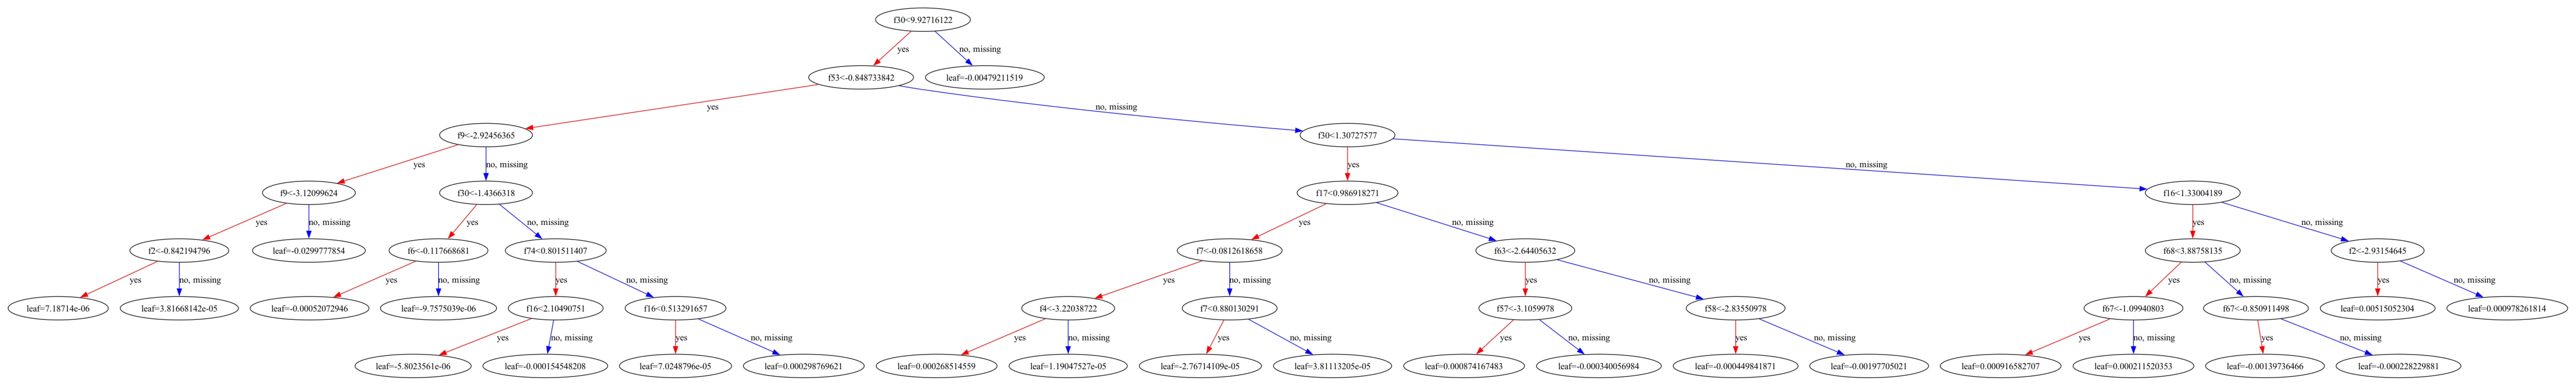

In [9]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(60, 30), dpi=300)
plot_tree(booster, num_trees=0, ax=ax)
plt.savefig("xgboost_tree_hd.png", bbox_inches='tight')
plt.show()


In [18]:

def fetch_parquet_from_s3(bucket_name, year, month, day, trading_symbol):
    # construct S3 path for the partitioned parquet
    s3_path = f's3://{bucket_name}/year={year}/month={month:02d}/day={day:02d}/trading_symbol={trading_symbol}/data.parquet'
    dataset = ds.dataset(s3_path, format="parquet", partitioning="hive")
    df = dataset.to_table().to_pandas()

    return df

Test Starts here

In [ ]:
#downloaing one day of data from my aws
bucket_name = 'live-market-data'
year = 2025
month = 6
day = 26
trading_symbol = 'NIFTY2571725300PE'  # replace with what you wanna fetch
main_df = fetch_parquet_from_s3(bucket_name, year, month, day, trading_symbol)
main_df["Time"] = pd.to_datetime(main_df["Time"]).dt.time
start_time = pd.to_datetime("09:15:00").time()
end_time = pd.to_datetime("15:30:00").time()
main_df_new = main_df[(main_df["Time"] >= start_time) & (main_df["Time"] <= end_time)]
main_df_new.drop(columns = 'Unnamed: 0', axis = 1, inplace = True, errors = 'ignore')
main_df_new = main_df_new.rename(columns = {'bid_price': 'BuyPrice' , 'ask_price': 'SellPrice', 'bid_quantity': 'BuyQty', 'ask_quantity' : 'SellQty', 'last_price':'LTP', 'volume':'Volume', 'ltq':'LTQ'})
main_df = main_df_new.copy()
main_df.reset_index(inplace = True)

In [33]:
main_df

,index,Date,Time,instrument_token,trading_symbol,strike_price,LTP,LTQ,Volume,open_interest,BuyPrice,SellPrice,BuyQty,SellQty,year,month,day
0,0,2025-06-26,09:15:32.618000,12107266,NIFTY2571725300PE,25300.0,302.30,75,0,9975,270.55,283.65,75,75,2025,6,26
1,1,2025-06-26,09:15:32.711000,12107266,NIFTY2571725300PE,25300.0,302.30,75,0,9975,269.25,283.55,75,75,2025,6,26
2,2,2025-06-26,09:15:32.711000,12107266,NIFTY2571725300PE,25300.0,302.30,75,0,9975,268.30,283.55,75,75,2025,6,26
3,3,2025-06-26,09:15:33.696000,12107266,NIFTY2571725300PE,25300.0,302.30,75,0,9975,267.95,282.15,150,75,2025,6,26
4,4,2025-06-26,09:15:33.946000,12107266,NIFTY2571725300PE,25300.0,302.30,75,0,9975,269.00,282.15,150,75,2025,6,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25215,25215,2025-06-26,15:29:54.940000,12107266,NIFTY2571725300PE,25300.0,203.75,300,70425,25800,190.85,193.00,75,75,2025,6,26
25216,25216,2025-06-26,15:29:55.190000,12107266,NIFTY2571725300PE,25300.0,203.75,300,70425,25800,190.85,193.00,75,75,2025,6,26
25217,25217,2025-06-26,15:29:56.441000,12107266,NIFTY2571725300PE,25300.0,203.75,300,70425,25800,190.85,192.70,75,75,2025,6,26
25218,25218,2025-06-26,15:29:58.177000,12107266,NIFTY2571725300PE,25300.0,203.75,300,70425,25800,191.00,193.30,75,75,2025,6,26


In [9]:
main_df.to_csv('trial_dataset.csv')

In [10]:
main_df = pd.read_csv('trial_dataset.csv')

In [11]:
main_df

,Unnamed: 0,index,Date,Time,instrument_token,trading_symbol,strike_price,LTP,LTQ,Volume,open_interest,BuyPrice,SellPrice,BuyQty,SellQty,year,month,day
0,0,0,2025-03-21,09:15:04.642000,8960258,NIFTY25MARFUT,0.0,23187.90,75,11700,15414525,23181.35,23187.65,300,75,2025,3,21
1,1,1,2025-03-21,09:15:04.705000,8960258,NIFTY25MARFUT,0.0,23181.00,750,11700,15414525,23181.35,23187.65,300,75,2025,3,21
2,2,2,2025-03-21,09:15:04.813000,8960258,NIFTY25MARFUT,0.0,23180.25,300,20100,15414525,23180.20,23188.15,2100,300,2025,3,21
3,3,3,2025-03-21,09:15:05,8960258,NIFTY25MARFUT,0.0,23185.10,75,23850,15414525,23176.25,23184.55,450,300,2025,3,21
4,4,4,2025-03-21,09:15:05.266000,8960258,NIFTY25MARFUT,0.0,23175.10,150,23850,15414525,23176.25,23184.55,450,300,2025,3,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39868,39868,39868,2025-03-21,15:29:58.269000,8960258,NIFTY25MARFUT,0.0,23385.10,75,6666300,14943375,23381.60,23385.05,75,75,2025,3,21
39869,39869,39869,2025-03-21,15:29:58.745000,8960258,NIFTY25MARFUT,0.0,23385.10,75,6666300,14943375,23381.60,23385.05,75,75,2025,3,21
39870,39870,39870,2025-03-21,15:29:58.988000,8960258,NIFTY25MARFUT,0.0,23385.10,75,6666300,14943375,23381.60,23385.05,75,75,2025,3,21
39871,39871,39871,2025-03-21,15:29:59.160000,8960258,NIFTY25MARFUT,0.0,23384.50,75,6666375,14943375,23381.65,23384.40,75,75,2025,3,21


In [12]:
main_df.drop(columns=['Unnamed: 0', 'index'], inplace=True, axis = 1)
main_df

,Date,Time,instrument_token,trading_symbol,strike_price,LTP,LTQ,Volume,open_interest,BuyPrice,SellPrice,BuyQty,SellQty,year,month,day
0,2025-03-21,09:15:04.642000,8960258,NIFTY25MARFUT,0.0,23187.90,75,11700,15414525,23181.35,23187.65,300,75,2025,3,21
1,2025-03-21,09:15:04.705000,8960258,NIFTY25MARFUT,0.0,23181.00,750,11700,15414525,23181.35,23187.65,300,75,2025,3,21
2,2025-03-21,09:15:04.813000,8960258,NIFTY25MARFUT,0.0,23180.25,300,20100,15414525,23180.20,23188.15,2100,300,2025,3,21
3,2025-03-21,09:15:05,8960258,NIFTY25MARFUT,0.0,23185.10,75,23850,15414525,23176.25,23184.55,450,300,2025,3,21
4,2025-03-21,09:15:05.266000,8960258,NIFTY25MARFUT,0.0,23175.10,150,23850,15414525,23176.25,23184.55,450,300,2025,3,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39868,2025-03-21,15:29:58.269000,8960258,NIFTY25MARFUT,0.0,23385.10,75,6666300,14943375,23381.60,23385.05,75,75,2025,3,21
39869,2025-03-21,15:29:58.745000,8960258,NIFTY25MARFUT,0.0,23385.10,75,6666300,14943375,23381.60,23385.05,75,75,2025,3,21
39870,2025-03-21,15:29:58.988000,8960258,NIFTY25MARFUT,0.0,23385.10,75,6666300,14943375,23381.60,23385.05,75,75,2025,3,21
39871,2025-03-21,15:29:59.160000,8960258,NIFTY25MARFUT,0.0,23384.50,75,6666375,14943375,23381.65,23384.40,75,75,2025,3,21


In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

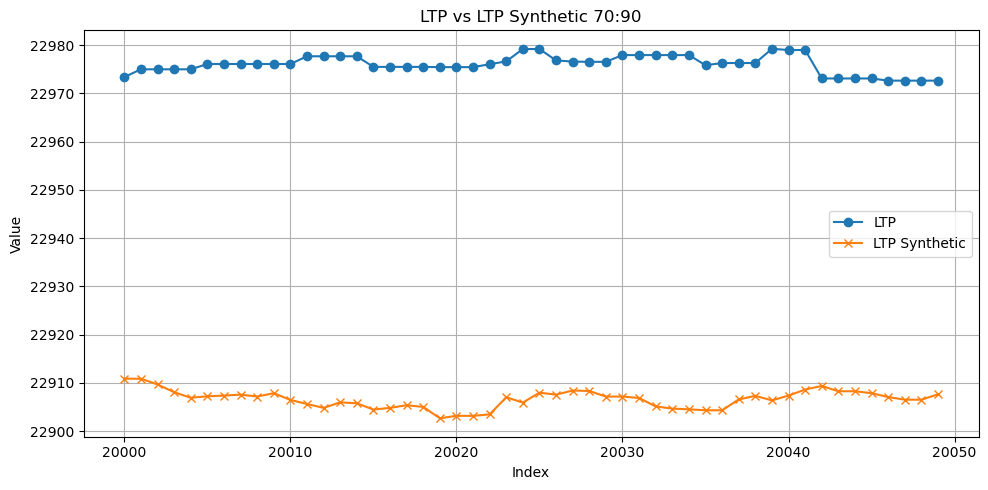

In [ ]:
'''import matplotlib.pyplot as plt

# Slice the DataFrame to get 20 rows
df_subset = main_df[['LTP', 'LTP Synthetic']][20000:20050]

plt.figure(figsize=(10, 5))

# Plot both columns as separate lines
plt.plot(df_subset.index, df_subset['LTP'], label='LTP', marker='o')
plt.plot(df_subset.index, df_subset['LTP Synthetic'], label='LTP Synthetic', marker='x')

plt.title("LTP vs LTP Synthetic 70:90")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

STARTS HERE

In [22]:

pred_main = []
ind_main = []
prev_comp = None
current_ticks = []  
bar_start = None        
bar_resampler = OHLCResampler()    


def market_sim(row, idx):

    global bar_start, current_ticks, prev_comp, ind_main, pred_main
    if 'datetime' not in row:
        row['Time'] = str(row['Time']).strip()
        row['datetime'] = pd.to_datetime(str(row['Date']) + ' ' + str(row['Time']),
                                          errors='coerce')    
    tick_time = row['datetime']
    if pd.isnull(tick_time):
        return
    if bar_start is None:
        bar_start = tick_time
        print(f"currently at {bar_start}")
    current_ticks.append(row)
    elapsed = (tick_time - bar_start).total_seconds()
    if elapsed >= t:
        bar_df = pd.DataFrame(current_ticks)
        resampled_df = bar_resampler.resample(bar_df)
        resampled_df_aggregated = resampled_df.groupby('Group').agg({      
                    'Date': 'last',         
                    'Time': 'last',        
                    'Open': 'first',
                    'High': 'max',
                    'Low': 'min',
                    'Close': 'last',
                    'BestBid': 'last',
                    'BestAsk': 'last',
                    'BidSize': 'last',
                    'AskSize': 'last',
                    'Volume': 'sum',
                    'GroupNumTime': 'last',
                    'TimePassed': 'sum', 
                    'GroupNum': 'last', 
                    'PrevBar': 'last',
                    'PrevPrevBar': 'last', 
                    'Session': 'last', 
                    'SessionBar': 'last'	
        }).reset_index()       
        if resampled_df_aggregated['GroupNum'][0] == 1:
            df_processed = generate_basic_variables(resampled_df_aggregated)
            prev_comp = df_processed.copy()
        else:
            df_processed = live_variable_generator(df=resampled_df_aggregated, prev_df=prev_comp)
            prev_comp = df_processed.copy()            

        features = df_processed[feature_columns]
        features = features.replace([np.inf, -np.inf], np.nan).fillna(0)            
        features_scaled = scaler.transform(features)
        predictions = model.predict(features_scaled)
        pred_main.append(predictions)      
        ind_main.append(idx + 1)      

        current_ticks = []
        bar_start = None    




In [23]:
for idx, row in main_df.iterrows():
    market_sim(row, idx)

currently at 2025-03-24 09:15:00.466000
currently at 2025-03-24 09:15:15.960000
currently at 2025-03-24 09:15:31.957000
currently at 2025-03-24 09:15:48.202000
currently at 2025-03-24 09:16:04.467000
currently at 2025-03-24 09:16:20.212000
currently at 2025-03-24 09:16:36.709000
currently at 2025-03-24 09:16:52.217000
currently at 2025-03-24 09:17:07.710000
currently at 2025-03-24 09:17:23.205000
currently at 2025-03-24 09:17:38.966000
currently at 2025-03-24 09:17:54.465000
currently at 2025-03-24 09:18:10.215000
currently at 2025-03-24 09:18:25.958000
currently at 2025-03-24 09:18:42.203000
currently at 2025-03-24 09:18:57.460000
currently at 2025-03-24 09:19:14.207000
currently at 2025-03-24 09:19:29.960000
currently at 2025-03-24 09:19:45.702000
currently at 2025-03-24 09:20:00.959000
currently at 2025-03-24 09:20:16.967000
currently at 2025-03-24 09:20:33.212000
currently at 2025-03-24 09:20:49.207000
currently at 2025-03-24 09:21:05.206000
currently at 2025-03-24 09:21:21.205000


In [24]:
def compute_pnl(main_df, ind_main, pred_main, min_hold_bars=0, verbose=True):
    pnl = 0
    count = 0
    position = None  # "long" or "short" or None
    entry_price = None
    hold_counter = 0  # counter for how long we've held a position

    for i in range(1, len(pred_main)):
        signal = pred_main[i]
        idx = ind_main[i]

        if idx < 0 or idx >= len(main_df):
            if verbose:
                print(f"Warning: index {idx} out-of-bounds (DataFrame length: {len(main_df)}). Skipping signal {i}.")
            continue

        price = main_df['LTP'].iat[idx]

        if position is None:
            # entry condition: only enter if there's a strong move
            if signal <= pred_main[i - 1] * 0.95:
                position = "short"
                entry_price = price
                hold_counter = 0
                if verbose:
                    print(f"Enter short at index {idx} (price {price}).")
            elif signal > pred_main[i - 1] * 1.05:
                position = "long"
                entry_price = price
                hold_counter = 0
                if verbose:
                    print(f"Enter long at index {idx} (price {price}).")
        else:
            # we are in a trade, increment the hold counter
            hold_counter += 1

            # exit condition only after min_hold_bars
            if hold_counter >= min_hold_bars:
                if position == "short" and signal > pred_main[i - 1] * 1.05:
                    exit_price = price
                    trade_pnl = entry_price - exit_price
                    pnl += trade_pnl
                    position = None
                    count += 1
                    if verbose:
                        print(f"Exit short at index {idx} (price {price}). Trade PnL: {trade_pnl}.")
                elif position == "long" and signal <= pred_main[i - 1] * 0.95:
                    exit_price = price
                    trade_pnl = exit_price - entry_price
                    pnl += trade_pnl
                    position = None
                    count += 1
                    if verbose:
                        print(f"Exit long at index {idx} (price {price}). Trade PnL: {trade_pnl}.")

    if position is not None:
        if verbose:
            print("Final open trade ignored; no exit signal provided.")

    return pnl, count

pro , trades = compute_pnl(main_df, ind_main, pred_main)
print(pro , trades)

Enter short at index 56 (price 23474.95).
Exit short at index 150 (price 23505.0). Trade PnL: -30.049999999999272.
Enter short at index 184 (price 23510.0).
Exit short at index 247 (price 23518.2). Trade PnL: -8.200000000000728.
Enter short at index 277 (price 23505.2).
Exit short at index 304 (price 23507.15). Trade PnL: -1.9500000000007276.
Enter long at index 330 (price 23510.0).
Exit long at index 402 (price 23501.8). Trade PnL: -8.200000000000728.
Enter long at index 487 (price 23514.6).
Exit long at index 511 (price 23518.6). Trade PnL: 4.0.
Enter short at index 538 (price 23523.1).
Exit short at index 567 (price 23524.0). Trade PnL: -0.9000000000014552.
Enter long at index 596 (price 23521.75).
Exit long at index 656 (price 23514.95). Trade PnL: -6.799999999999272.
Enter short at index 686 (price 23517.0).
Exit short at index 718 (price 23505.55). Trade PnL: 11.450000000000728.
Enter short at index 750 (price 23499.1).
Exit short at index 841 (price 23495.7). Trade PnL: 3.399999

PROFIT = 165
NO of Trades = 552

now, this profit is captured on futs

so for 1 delta calls, we captured movement of Rs.165

1 lot ~ Rs. 50 per share

Assuming no slippage for easy calculations

Buy 1000 lots each time

Spread across liquid Strikes across expiry and across indexes, the model performs almost the same across indexes

500 (Lots)   x     75 (Shares Per Lot)     x       50 (Rs per share)       =       18,75,000    x   2 (Buy Call Sell Put)       =       37,50,000
 Square off the same amount , so each trade = 75,00,000 (Blocked funds for shorting a put not included)

 550 trades per day = Combined volume = 4,12,50,00,000
 Charges = 0.1% of buy and sell volume = 41,25,000

 Revenue = 165 x 75 x 500 = 61,87,500

 Profit per day = 61,87,500 - 41,25,000 = 20,62,500

 Accounting for loss making days, currently we are at 4 Lakh per crore